# TensorFlor CNN and image processing

This notebook contains the python code responsible for loading, processing and labeling the images taken by our camScript.py program on our Raspberry Pi 5. The notebook also contains the code for our CNN model specification and code for using the model.

The model in use is a sequential model.

After building the model, we feed it a test image and see if it can correctly classify it.

We also have code in this file for converting the model to a TFLite model, which is smaller in size, such that it can hopefully live on a microcontroller.

In [2]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
to_categorical = tf.keras.utils.to_categorical

# Global variables
size=192 # size is the dimention of the (square) image

2025-05-06 12:47:50.220977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 12:47:50.236543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746528470.250180   95556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746528470.253802   95556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746528470.262856   95556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Image Processing

This python program was created to, process the images, which will be used to train our CNN. 

The program loads the images from the 'Puctures' directory, then rotates them 90 degrees clockwize, to make them appear up right.


In [ ]:
'''
1. https://www.geeksforgeeks.org/image-processing-in-python/
2. ChatGPT
3. https://www.photopea.com/
4. https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
'''

x_data = []
y_data = []

# Define parameters
DATASET_PATH = "../Local_Things/Pictures"
OUTPUT_DIR = "../Local_Things/processed_pictures"
IMAGE_SIZE = (size,size) # final image size after processing
img_start_x, img_start_y =  1125, 552 # start parameters for cropping
crop_amount = 2002 #cropping parameter

os.makedirs(OUTPUT_DIR, exist_ok=True)


class_names = sorted(os.listdir(DATASET_PATH))  # Ensures labels are consistent
class_indices = {name: idx for idx, name in enumerate(class_names)}  # Assigns class numbers


# Process each class folder
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping {img_name}, could not read.")
            continue
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Cropping image
        img = img[img_start_y:img_start_y+crop_amount, img_start_x:img_start_x+crop_amount]
        img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)

        # Rotate
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
        img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

        # Save BEFORE normalization
        class_path_output = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(class_path_output, exist_ok=True)
        save_path = os.path.join(class_path_output, img_name)
        Image.fromarray(img).save(save_path)

        # Normalize pixel values
        img = preprocess_input(img)

        x_data.append(img)
        y_data.append(class_indices[class_name])


In [3]:

# Define image parameters
IMAGE_SIZE = (size,size)
DATASET_PATH = "../Local_Things/Pictures"
OUTPUT_DIR = "../Local_Things/processed_pictures"
img_start_x, img_start_y =  1125, 552
crop_amount = 2002
# Lists to store images and labels
x_data = []
y_data = []

# Get class names from directory
class_names = sorted(os.listdir(DATASET_PATH))  # Ensures labels are consistent

class_indices = {name: idx for idx, name in enumerate(class_names)}  # Assigns class numbers

# Process each class folder
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping {img_name}, could not read.")
            continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img = img[img_start_y:img_start_y+crop_amount,img_start_x:img_start_x+crop_amount]
        img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)

        # Rotate image if needed
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
        img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

        # Normalize pixel values (optional but recommended)
        # img = preprocess_input(img)

        # Store processed image and corresponding label
        x_data.append(img)
        y_data.append(class_indices[class_name])  # Integer label

img_for_saving = np.array(x_data,dtype=np.uint8)

# Save processed images to disk
for idx, (img_array, label_idx) in enumerate(zip(x_data, y_data.argmax(axis=1))):
    label_name = class_names[label_idx]
    label_folder = os.path.join(OUTPUT_DIR, label_name)
    os.makedirs(label_folder, exist_ok=True)

    # Convert image array back to uint8 and PIL format if needed
    img_to_save = Image.fromarray(np.uint8(img_array))

    # Define a filename
    filename = f"{label_name}_{idx}.png"
    img_to_save.save(os.path.join(label_folder, filename))


# Convert lists to NumPy arrays
x_data = np.array(x_data, dtype=np.int32)
y_data = np.array(y_data, dtype=np.int32)

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, num_classes=len(class_names))

# Split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Plot images to see of they are processed correctly
def plot_images(images, labels, class_names, images_per_row=5):
    total_images = len(images)
    rows = math.ceil(total_images / images_per_row)  # Calculate needed rows

    plt.figure(figsize=(images_per_row * 3, rows * 3))  # Adjust figure size dynamically
    
    for i in range(total_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Amount of images: " + str(len(x_train)))
plot_images(x_train, y_train, class_names)

AttributeError: 'list' object has no attribute 'argmax'

## CNN Model Training

We're using a sequencial model from the getting started section of the tensorflow website:
https://www.tensorflow.org/tutorials/quickstart/beginner

In [9]:
# Define a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

print(y_train.shape)

# Compile the model with correct loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizers.Adam(learning_rate=4e-4), loss=loss_fn, metrics=['accuracy'])

# Ensure x_train and y_train are in the correct format
print(f"x_train shape: {x_train.shape}")  # Should be (num_samples, 150, 150, 3)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples,)

# Train the model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluate on test set
model.evaluate(x_test, y_test, verbose=2)

# Create a probability model for predictions
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

# Get predictions
predictions = probability_model(x_test[:5])
print(predictions)


/home/bdamunix123/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(176, 2)
x_train shape: (176, 192, 192, 3)
y_train shape: (176, 2)
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.4764 - loss: 1173.1335 - val_accuracy: 0.5455 - val_loss: 378.7217
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.8134 - loss: 331.9545 - val_accuracy: 0.9318 - val_loss: 37.7609
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.9265 - loss: 115.8277 - val_accuracy: 0.9773 - val_loss: 32.1871
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.9764 - loss: 32.5263 - val_accuracy: 0.9318 - val_loss: 89.9867
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.9735 - loss: 33.1935 - val_accuracy: 0.9318 - val_loss: 45.3995
2/2 - 0s - 83ms/step - accuracy: 0.9318 - loss: 45.3995
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(5, 2), dtype=float32)


## Save the model (Size: 122M)

In [4]:
model.save("my_model.h5")

## Convert model to TFLite model (Size 11M)

The idea is to have a model that will fit on a microcontroller. The model will still be trained on a device with the necessary capabilities.

By converting the model to a TFLite model, and using the converter.optimizations method as shown below, we have managed to reduce the size of the model from 122M to 11M.

In [5]:
# Load the model
MODEL_PATH = "my_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert all float32 to int8, minimizing the model, making it about 4 times smaller.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'my_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpkro2o6jn/assets


INFO:tensorflow:Assets written to: /tmp/tmpkro2o6jn/assets


Saved artifact at '/tmp/tmpkro2o6jn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140651459204672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459209952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459113584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459112704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459592608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459103728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651459109184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140651289565440: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745851366.729962  179503 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745851366.730021  179503 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-28 16:42:46.730370: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkro2o6jn
2025-04-28 16:42:46.730938: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-28 16:42:46.730947: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkro2o6jn
I0000 00:00:1745851366.736148  179503 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-28 16:42:46.736958: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-28 16:42:46.854177: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkro2o6jn
2025-04-28 16:42:46.867965: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [11]:
IMAGE_SIZE = (size, size)  # Same as training size
IMAGE_PATH = "../Local_Things/Test_images/Cress1_2025-03-03_07:40:14.jpg"  # Replace with actual image path

# for measuring energy consumption 
from pyJoules.energy_meter import measure_energy

# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img[img_start_y:img_start_y+crop_amount,img_start_x:img_start_x+crop_amount] # Crop
    img = cv2.resize(img, IMAGE_SIZE)  # Resize
    center = (img.shape[1] // 2, img.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
    img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    img = preprocess_input(img)  # Normalize
    img_expanded = np.expand_dims(img, axis=0)  # Add batch dimension
    return img, img_expanded  # Return both original and processed images

@measure_energy
def foo():
# Preprocess input image
    original_image, image = preprocess_image(IMAGE_PATH)

foo()

begin timestamp : 1746282004.1281939; tag : foo; duration : 0.05924582481384277; package_0 : 1548458.0; core_0 : 1303036.0; uncore_0 : 20630.0


# Using the trained model (the original, not the tfLite)

In [ ]:
# Define constants

MODEL_PATH = "my_model.h5"  # Path to your trained model

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Get model prediction
prediction = model.predict(image)

# Convert probabilities to class label
predicted_class = np.argmax(prediction)  # 0 or 1

# Define class names (Modify according to your dataset)
class_names = ["Not ready", "Ready"]  # Replace with actual class names
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 246016, but received input with shape (1, 135424)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 192, 192, 3), dtype=uint8)
  • training=False
  • mask=None

## Using the tfLite Model

/home/bdamunix123/.local/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Class Probabilities: [[0. 1.]]


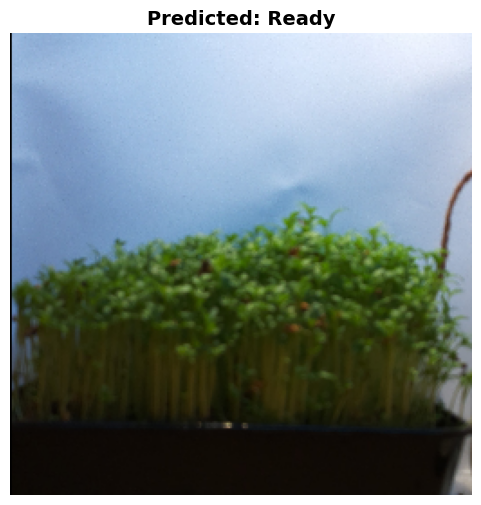

In [7]:
MODEL_PATH = "my_model.tflite"  # Path to your trained model

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess input image
original_image, image = preprocess_image(IMAGE_PATH)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image.astype(np.float32))

# Run inference
interpreter.invoke()

# Get output tensor
prediction = interpreter.get_tensor(output_details[0]['index'])

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(prediction).numpy() 

# Convert to class label (the one with the highest probability)
predicted_class = np.argmax(probabilities)  # 0 or 1

# Print out the probabilities
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

## Training and using MobileNet v3 model with our own data

## Instansiating the MobileNetV3 Model
MobileNetv3 is an existing CNN architechture made for mobile devices. We want to see if we can use this architechture, to both get precise results and have a model that is small enough to fit on a micro-controller. The MobileNetV3Small architecture is instantiated below. We have made a few changes. The input_shape has been defined to match the shape of our data. "inlude_top" has been set to false, allowing us to add our own classification layer. "minimalistic" has been set to True (Explain what this does). Besides being a different architechture, this model is unlike the one we made from scratch, trained on the imagenet dataset. This pretraining should contribute to how well the model performs. 

## Adding a classification layers
The classification layers are added such that the model will choose between our classes, when performing classification. In other words, when given an image, the model will output either "ready" or "not_ready". 

## Parameters to consider
When working with CNN's there are several important parameters to consider. These parameters have an effect of both the accuracy and the efficiency of the model.

### Learning rate
The Learning rate is specified in the optimizer with which we compile the model. The learning rate has an effect on the accuracy and loss of the model. This paper (source) presents research on how the learning rate can effect a CNN. The research consisted of compiling a model with different learning rates, and noting the effects on accuracy and loss. The same method of testing the MobileNet model with different learning rates let to the resulting learning rate of "0.0008". This learning rate resulted in the highest accuracy and the lowest loss.

source: (https://d1wqtxts1xzle7.cloudfront.net/66521533/effect_of_learning_rate_on_neural_IJERTCONV6IS17007-libre.pdf?1619161249=&response-content-disposition=inline%3B+filename%3DIJERT_Effect_of_Learning_Rate_on_Neural.pdf&Expires=1745858090&Signature=InV806wvcycLy8rCaGISkmC6-2ROPpiZzgmsvaHbtH~ZxHR-UV2lFmjMNNdSyZGdRAoiciduVbmWVLvYgPdi8cSSGJUD~Y6frionZlW75d08Zxi1Erxqz5RFAdSEV8L4slJFYgLjxDBF6mr9CcMHsmYl~oUW8VoD~Nveb9PrHWGGLfIlwEpgmi2ZWpWM1HuMFVTdQEC62x4D3oxWVMWmHkheVz1rZOx4g92OTLSPyOhp0C7gBMm-jwVe9EgKGpfao5hpm-sUESEi7lc7dfaAwJ-ytREdoIpohWtS~TSYfOc2xfKdOgTLTrBQJxKhfXgIUyuWk~CknzYU6Pewejh4cQ__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)

### Epochs
When training a CNN, it is possible to specify an amount of epochs. In an epoch, the model has seen the entire training dataset, so with multiple epochs, the model gets trained over multiple iterations. Like the learning rate, the amount of epochs have an effect on the models accuracy and loss. 

source: https://www.sciencedirect.com/science/article/pii/S0168169920302258

### Width multiplyer (Alpha) (MobileNet only)
MobileNet models are designed to be small and efficient in order to run on mobile or embedded devices. While this model is the smallest of the ones we've used, it is interesting to see how small the model can become. The mobileNet architechture has two parameters, which has an effect on the size of the model, one of which is the width multiplyer, also called (α) Alpha. The width multiplyer reduces the computational cost of the model, and reduces the amount of parameters by α^2. When working with a model which is pretrained in imagenet, which it is in our case, it is possible to set the width multiplyer to either 1.0 with minimalistic=True or for minimalistic=False, either 1.0 or 0.75. When reducing the width multiplyer to 0.75, the final model, after being converted to a tfLite model with DEFAULT optimizations, had a size of 766K, which is slightly bigger than that of a minimalistic mobileNet model, with its size of 605K.

When not pretraining the model with the imagenet dataset however, it is possible to set the alpha to an even lower value, while keeping minimalistic true. In order to see how small a model could become, models with width multiplyers of 0.50 and 0.25 were created, both with and without minimalistic=True. This resulted in the following results:

    MobileNetV3SmallAlpha50.tflite: 427K
MobileNetV3SmallAlpha50Mini.tflite: 241K
    MobileNetV3SmallAlpha25.tflite: 224K
MobileNetV3SmallAlpha25Mini.tflite: 133K

Without pretraining on imagenet, the smallest model which were created had a size of just 133K, however non of the models that were not pretrained had a good accuracy and had a very high loss.

Source: https://arxiv.org/pdf/1704.04861

### Resolution multiplyer (MobileNet only) (Maybe to be written)

## Results
The MobileNetV3Small model reached an accuracy of (acc) and a loss of (los). The goal of using exactly this model was to see if it was possible to get a working model down to a size which could fit on a micro-controller. After converting the model to a tfLite model, with the DEFAULT optimization constant, the size of the MobileNetV3Small model became just (size), reduced from its original size of (og_size).


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.7714 - loss: 0.4688 - val_accuracy: 0.6136 - val_loss: 0.8510
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.5909 - val_loss: 1.3467
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.6136 - val_loss: 1.5172
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.6364 - val_loss: 1.5074
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.7045 - val_loss: 1.0760
2/2 - 0s - 59ms/step - accuracy: 0.7045 - loss: 1.0760


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
Class Probabilities: [[0.26894143 0.73105854]]


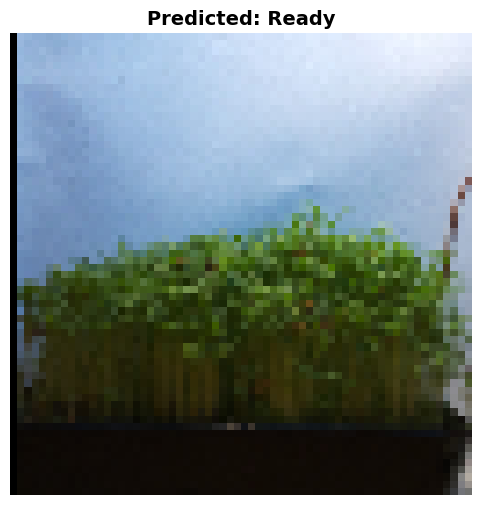

In [ ]:
# https://www.kaggle.com/models/timm/tf-mobilenet-v3
# Made with help from chatGPT

# We have a model: "MobileNetV3SmallAlpha75.tflite", with alpha=75 and minimalistic=False, weight='imagenet', 
# to see if this specificaiton was smaller than minimalistic model.
# Minimalistic model: 605K, Alpha75 model: 766K

# With out imagenet pretraining, it is possible to set the alpha to 0.50. This makes the model terrible, but the size of this model calles:
# MobileNetV3SmallAlpha50.tflite has a size of just 427K, A version of this model with minimalistic=True was made, called 
# MobileNetV3SmallAlpha50Mini.tflite had a size of 241K

# Finally models MobileNetV3SmallAlpha25.tflite and MobileNetV3SmallAlpha25Mini.tflite were created with sizes: 224K and 133K respectivly

# To see the change in accuracy, when chaning the resolution multiplier, the model was trained on images of sizes:
# 256 - accuracy: 0.8864 - loss: 0.1537
# 192 - accuracy: 1.0000 - loss: 0.0233 <-- (Interesting)
# 128 - accuracy: 0.9545 - loss: 0.1008
# 64  - accuracy: 0.7045 - loss: 1.0760
# Alle of the above models had alpha=1, minimalistic=True, learning rate=0.0008, 5 epochs.

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(size, size, 3),
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)

# Classification layers
mobileNetv3_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # Adjust based on number of classes
])

# Set learning rate to 
# 0.003:    accuracy: 0.8636 - loss: 0.2542
# 0.001:    accuracy: 0.9318 - loss: 0.3103
# 0.0008:   accuracy: 0.9773 - loss: 0.0473 <--
# 0.0006:   accuracy: 0.9318 - loss: 0.1382
# 0.0003:   accuracy: 0.9773 - loss: 0.1090
# 0.00008:  accuracy: 0.7727 - loss: 0.4245

mobileNetv3_model.compile(optimizer=optimizers.Adam(learning_rate=0.0008), loss='categorical_crossentropy', metrics=['accuracy'])

mobileNetv3_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

mobileNetv3_model.evaluate(x_test, y_test, verbose=2)

prediction = mobileNetv3_model.predict(image)

predicted_class = np.argmax(prediction)
# Convert probabilities to class label
class_names = ["Not ready", "Ready"]  # 0 or 1
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

### Saving the MobileNetV3Small model (Size: 12M)

In [ ]:
mobileNetv3_model.save("MobileNetV3Small.h5")

INFO:tensorflow:Assets written to: /tmp/tmpoozmqbyg/assets


INFO:tensorflow:Assets written to: /tmp/tmpoozmqbyg/assets


Saved artifact at '/tmp/tmpoozmqbyg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_322')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139726997276800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727002001024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727002004720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727002005600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727001999440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139726999040800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727000845504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727000830720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727000836704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139727000836176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397270049

W0000 00:00:1745933627.231338  288317 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745933627.231411  288317 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-29 15:33:47.231652: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpoozmqbyg
2025-04-29 15:33:47.240341: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-29 15:33:47.240366: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpoozmqbyg
2025-04-29 15:33:47.331430: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-29 15:33:48.045968: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpoozmqbyg
2025-04-29 15:33:48.281540: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1049892 microseconds.


## Training and using EfficientNet v2 model with our own data

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8024 - loss: 0.4223 - val_accuracy: 0.9545 - val_loss: 0.1591
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9821 - loss: 0.0536 - val_accuracy: 0.9545 - val_loss: 0.1112
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9882 - loss: 0.0264 - val_accuracy: 0.9318 - val_loss: 0.1542
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9808 - loss: 0.0254 - val_accuracy: 0.9773 - val_loss: 0.0340
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0079
2/2 - 1s - 412ms/step - accuracy: 1.0000 - loss: 0.0079


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class Probabilities: [[0.26993796 0.730062  ]]


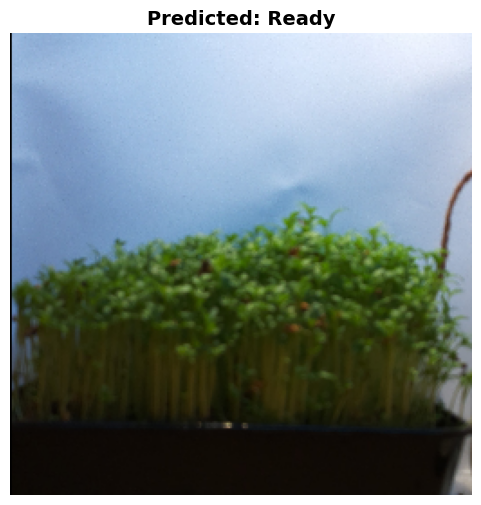

In [11]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

# Load EfficientNetV2B0 model
base_model = EfficientNetV2B0(input_shape=(size, size, 3), include_top=False, weights='imagenet')  # Pretrained on ImageNet
#base_model.trainable=False

# Add classification layers on top
EfficientNetV2B0_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # Adjust for your number of classes
])

# Compile the model (if needed)
EfficientNetV2B0_model.compile(optimizer=optimizers.Adam(learning_rate=4e-4), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetV2B0_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

EfficientNetV2B0_model.evaluate(x_test, y_test, verbose=2)

prediction = EfficientNetV2B0_model.predict(image)

predicted_class = np.argmax(prediction)
# Convert probabilities to class label
class_names = ["Not ready", "Ready"]  # 0 or 1
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

### Saving the EfficientNetV2B0 model (Size 70M)

In [ ]:
EfficientNetV2B0_model.save("EfficientNetV2B0.h5")

## Thoughts

Our own trained model has a very high accuracy and low loss compared to MobileNetV3Small and EfficientNetv2B0.
Our TFLite model has a size of 11M, shrinked from the original 122M

The results show that when feeding the models a test image, our own model is alot better at classifying.

Maybe the Mobilenet and efficientNet models are trash because they expext some specific input size.

The mobileNet model needs to be quantized in order to reduce the size enough to fit in on a microcontroller.

## Quantizing the MobileNet model (making it smaller)

In [ ]:
# Load the model
MODEL_PATH = "MobileNetV3Small.h5"

from tensorflow.keras.utils import get_custom_objects

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects=get_custom_objects()
)

# Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert all float32 to int8, minimizing the model, making it about 4 times smaller.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'MobileNetV3Small.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)